# Capstone - Predicting Titanic Passenger Survival

# Introduction
This project will attempt to predict the wether or not a passenger survived the sinking of The Titanic. I discovered this machine learning project while browsing the competitions on https://www.kaggle.com/. 

My goal is to win this competition, using the skills I have learned throughout the Elite Data Science Machine Learning Accelerator course! The general consenus amongst the community is that a score of 0.85 is possible, therefore this is my win condition for this project.

### Dataset information
Two datasets are provided in csv format - train.csv and test.csv. The test.csv dataset contains the unknowns and will be used to submit the survival prediction to the competion.

The train.csv dataset consists of 891 obervations, 10 features and 1 target variable. It contains a mixture of data types. Each observation refers to a unique passenger.

The data dictionary can be found here https://www.kaggle.com/c/titanic/data

### Acknowledgements
https://www.kaggle.com/c/titanic/overview

### Project findings
The winning model is a gradient boosting classifier with an AUROC score 0.874. Some data cleansing and the engineering of several new features is required to produce the analytical base table. This table is then the base from which to train and test with a hyperparameter grid. 

### Machine learning problem
Predicting the survival of a passenger is a classification problem. This project compares different classification algorithims, and identifies the best performing algorithm for this dataset.

### About me
As a data enthusiast, there was no formal computer science, mathematics, or statistics education for me. However, I value continuous learning and I hope that this machine learning project will showcase much of what I have learned through the Elite Data Science Machine Learning Accelerator course. 


# Library Imports

In [409]:
# NumPy for computation
import numpy as np

# Pandas for dataframes
import pandas as pd
pd.set_option('display.max_columns', 100)

# matplotlib for visualization config
from matplotlib import pyplot as plt
%matplotlib inline

# seaborn for easy visualization
import seaborn as sns
sns.set_style('darkgrid')

# scaler to scale numerical features
from sklearn.preprocessing import StandardScaler

# ensemble algos
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# metrics
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

# train test split, grid search for hyperparameter sweep
from sklearn.model_selection import train_test_split, GridSearchCV

# pipeline
from sklearn.pipeline import make_pipeline

# Pickle for reading model files
import pickle

## Exporatory analysis (Part 1)

Basic information
* 891 observations, 10 features, 1 target variable, 1 index
* 38% of the observations where Survived is true
* PassengerId is unique and can be used as index
* There are no duplicate observations
* There are missing values in Age, Cabin, Embarked

Categrorical features
* Name, Sex and Embarked appear intuituve
* Ticket contains many duplicates
* Cabin contains many missing values

Continuous features
* Age and Fare both have unusual distributions
* Fare is duplicated per ticket

Ordinal features
* Pclass appears intuitive

Relationships
* Pclass and Fare are to some extent correlated with survival
* SibSp and ParCh show some correlation

Next steps
* data cleaning is now required to fill missing values 



In [410]:
# train.csv to dataframe
df = pd.read_csv('train.csv')
print(df.shape)
df.head(3)

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [411]:
# check for nulls and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [412]:
# check for unique IDs
df.PassengerId.nunique()

891

In [413]:
# check for duplicated observations
df.duplicated().sum()

0

In [414]:
# statistics for numerical features and target
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


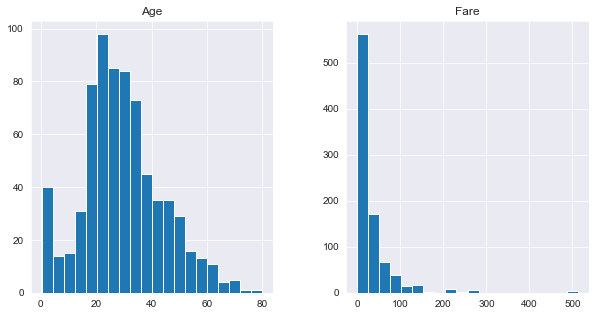

In [415]:
# plot distributions for continious features
df[['Age', 'Fare']].hist(bins=20, figsize=(10, 5))
plt.show()

In [416]:
# statistics for categorical features
df.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Myhrman, Mr. Pehr Fabian Oliver Malkolm",male,CA. 2343,G6,S
freq,1,577,7,4,644


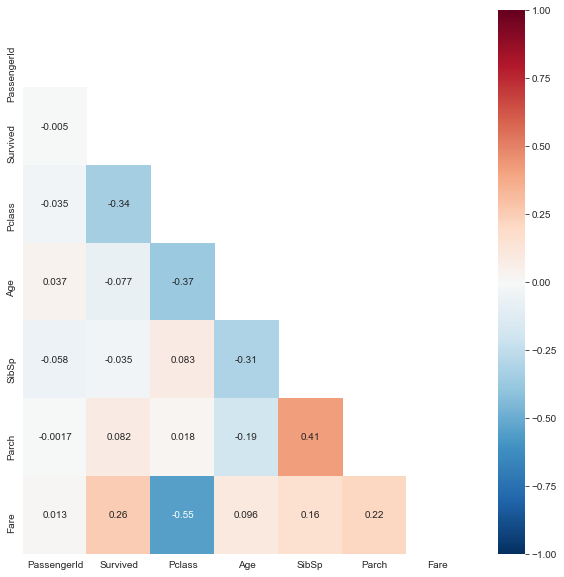

In [417]:
# plot correlation matrix
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = 1

sns.set_style('whitegrid')
plt.figure(figsize=(10,10))

sns.heatmap(corr,
            mask=mask,
            annot=True,
            cmap='RdBu_r',
            vmax=1,
            vmin=-1           
           )
plt.show()
sns.set_style('darkgrid')

## Ad-hoc data cleaning

Missing feature values
* Embarked
    * Missing values have a comparible Pclass and Fare where Emabarked = Q
    * replacing missing values with Q
* Cabin

* Age
    
   

In [418]:
# train.csv to dataframe with index
df = pd.read_csv('train.csv', index_col='PassengerId')
print(df.shape)
df.head(3)

(891, 11)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


### Clean feature: Embarked

In [419]:
# show observations where Emarked is missing
df[df.Embarked.isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [420]:
# fill missing Embarked values 
df.Embarked.fillna('Missing', inplace=True)

In [421]:
# compare Embarked and Pclass by Fare
(df.assign(count = 1)
 .groupby(['Embarked', 'Pclass'])
 .agg({'Fare': 'mean', 'count': 'sum'})
)


Fare  count
Embarked Pclass                   
C        1       104.718529     85
         2        25.358335     17
         3        11.214083     66
Missing  1        80.000000      2
Q        1        90.000000      2
         2        12.350000      3
         3        11.183393     72
S        1        70.364862    127
         2        20.327439    164
         3        14.644083    353

In [422]:
# replace missing values with Q
df.Embarked.replace({'Missing': 'Q'}, inplace=True)

### Clean feature: Cabin

In [423]:
# show observations where Cabin is missing
df[(df.Cabin.isnull())].head(3)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250,NaN,S
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,NaN,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.050,NaN,S


In [424]:
# replace missing values
df.Cabin.fillna('Missing', inplace=True)

In [425]:
# check value counts
df.Cabin.value_counts()


Missing        687
B96 B98          4
C23 C25 C27      4
G6               4
E101             3
              ... 
D30              1
C32              1
E40              1
E10              1
A32              1
Name: Cabin, Length: 148, dtype: int64

### Clean feature: Age

In [427]:
# get median Age by Pclass and Embarked
age_group_df = (
df.groupby(['Embarked', 'Pclass'])
 .agg({'Age': 'median'})
 .rename({'Age': 'age_group_median'}, axis = 1)
)


In [428]:
# merge age_group_df
df = (df.reset_index()
      .merge(age_group_df, on=['Embarked', 'Pclass'])
      .set_index('PassengerId')
     )
df.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_group_median
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250,Missing,S,25.0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,Missing,S,25.0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.050,Missing,S,25.0


In [429]:
# replace missing Age values by dividing the Fare value by the fare_age_pc value
df['Age'] = np.where(df.Age > 0, df.Age, df.age_group_median)

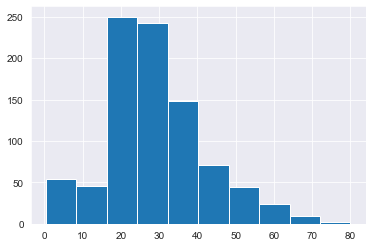

In [430]:
df.Age.hist(bins=10)
plt.show()

### Clean feature: Fare

Distributions show further investigation of Age and Fare (continuous scale) required

In [431]:
# get number of count (size) of each ticket
df_ticket_size = (df.groupby(['Ticket'])
                  .size()
                  .reset_index()
                  .rename({0: 'ticket_size'}, axis=1)
                 )

In [432]:
# merge df_ticket_size
df = (df.reset_index()
      .merge(df_ticket_size, on=['Ticket'])
      .set_index('PassengerId')
     )   


In [433]:
# calculate the price paid per person
df['price_per_person'] = df.Fare / df.ticket_size

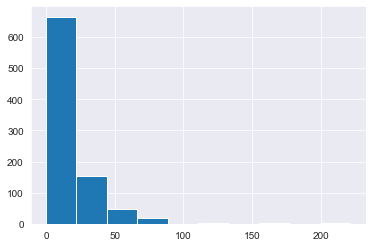

In [438]:
# plot distribution of price
df.price_per_person.hist(bins=10)
plt.show()

## Exploratory analysis (part 2)

Since this is a classification tasks, the target variable is categorical. Therefore, key numeric features will be segmented by the target variable.

Judging by the resulting plots, a decision can be made to create new features. These features will also take care of sparse classes and outliers.

* create binary features
    * is_female
    * cabin_missing
    * is_without_family (Parch + SibSp == 0)
    
* create groups
    * ticket_size (1, 2-4, 5+)
    * Age
    * price_per_person
    
* create dummy features
    * Pclass
    * Embarked

In [441]:
# get first string of Cabin for count plot
df['cabin_group'] = df.Cabin.str.slice(stop=1)

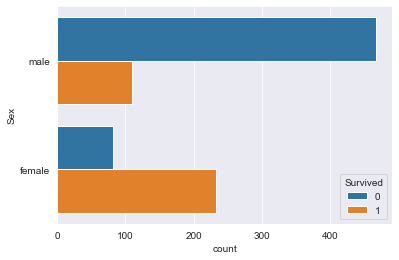

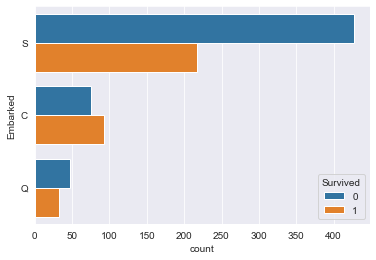

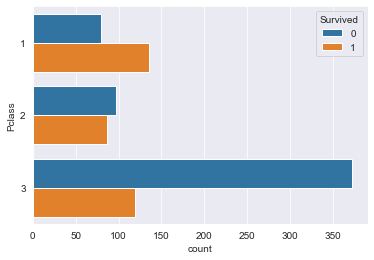

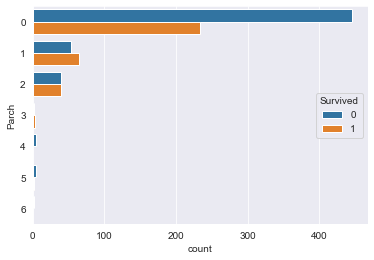

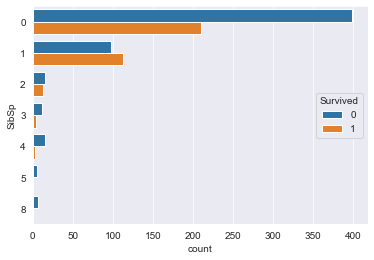

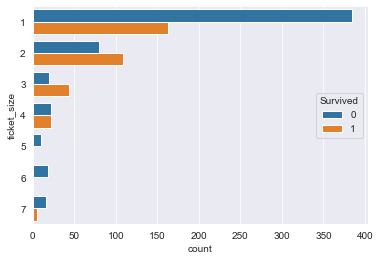

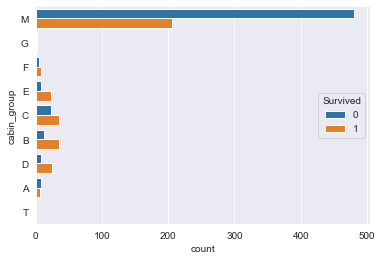

In [442]:
# loop round categorical features
# compare segments by target variable
for col in ['Sex', 'Embarked', 'Pclass','Parch', 'SibSp', 'ticket_size', 'cabin_group']:
    sns.countplot(y=col,
                  data=df,
                  hue='Survived'
                 )

    plt.show()

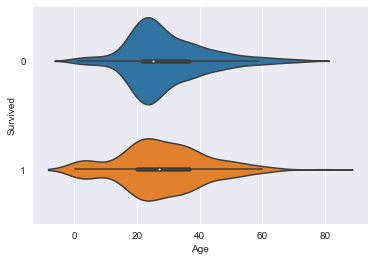

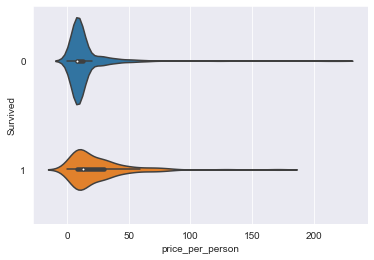

In [443]:
# loop round continous variables
# violin plot to examine distributions
for col in ['Age', 'price_per_person']:
    sns.violinplot(x=col,
                   y='Survived', 
                   data=df,
                   orient='h'
                  )
    plt.show()

## Ad-hoc feature engineering
This section is used to create the new features, plot segments and decide if they should be used in the model.

### Binary features

In [444]:
# is_female
df['is_female'] = (df.Sex == 'female').astype(int)

# cabin_is_missing
df['cabin_is_missing'] = (df.cabin_group == 'M').astype(int)

# is_without_family
df['is_without_family'] = (df.Parch + df.SibSp == 0).astype(int)

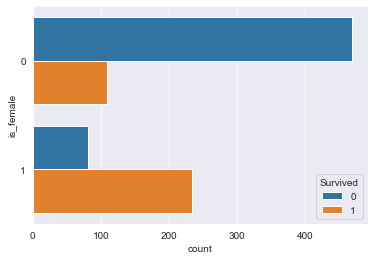

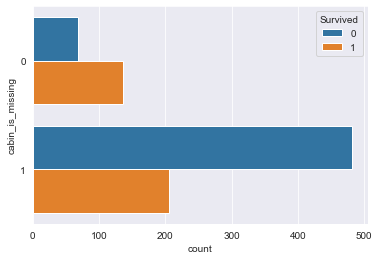

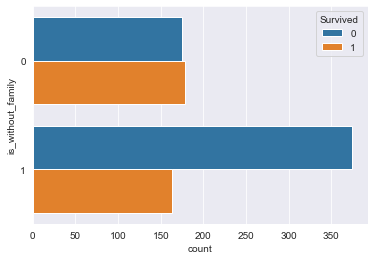

In [445]:
# plot binary features
# compare segmentations

for col in ['is_female', 'cabin_is_missing', 'is_without_family']:
    sns.countplot(y=col,
                  data=df,
                  hue='Survived'
                 )
    plt.show()

### Group continuous features

In [446]:
# show quartiles
df.Age.describe()

count    891.000000
mean      28.900303
std       13.349863
min        0.420000
25%       21.000000
50%       26.000000
75%       36.500000
max       80.000000
Name: Age, dtype: float64

In [447]:
# https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/
# create list of conditions
# if quartiles do not display differing survival rates, change the conditions
age_conditions = [
(df.Age <= 10),
(df.Age <= 30),
(df.Age <= 50),
(df.Age > 50)    
]

# create list of values
age_groups = [
    1,
    2,
    3,
    4
]

df['age_group'] = np.select(age_conditions, age_groups).astype('object')

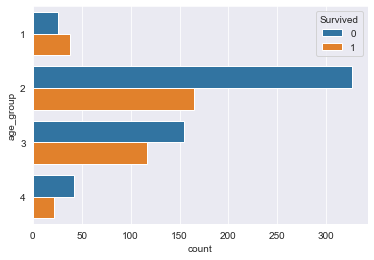

In [448]:
# plot age_group
# check segmentations
for col in ['age_group']:
    sns.countplot(y=col, 
                  data=df,
                  hue='Survived'
                 )
    plt.show()

In [449]:
# show quartiles
df.price_per_person.describe()

count    891.000000
mean      17.788989
std       21.218157
min        0.000000
25%        7.762500
50%        8.850000
75%       24.288200
max      221.779200
Name: price_per_person, dtype: float64

In [450]:
# create list of conditions
# if quartiles do not display differing survival rates, change the conditions
price_conditions = [
    (df.price_per_person <= 10),
    (df.price_per_person <= 25),
    (df.price_per_person > 25)
]

# create list of values
price_groups = [
    1,
    2,
    3
]

df['price_group'] = np.select(price_conditions, price_groups).astype('object')

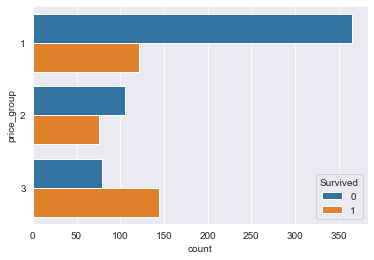

In [451]:
for col in ['price_group']:
    sns.countplot(y=col, 
                  data=df,
                  hue='Survived'
                 )
    plt.show()

## Advanced segmentations

Search for clusters in bivariate segmentation

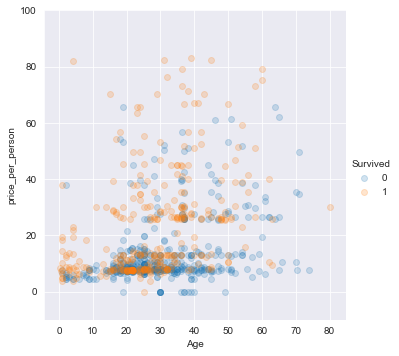

In [290]:
# bivariate plot continuous features
sns.lmplot(x='Age',
           y='price_per_person',
           hue='Survived',
           data=df,
           fit_reg=False,
           scatter_kws={'alpha':0.2},
           height=5
)

plt.ylim(-10, 100)
plt.show()

## Section 4: Data Cleaning

This section will clean the data by

* dropping duplicates
* filling missing values

Although no duplicates were found in train.csv, they may exist in future data sets

In [452]:
def clean_data(df):
    
    # drop duplicates
    df.drop_duplicates(inplace=True)
    
    # fill missing Fare values
    df.fillna({'Fare': 0}, inplace=True)
    
    # fill missing Embarked values
    df['Embarked'] = np.where(df.Embarked.isnull(), 'Q', df.Embarked)
    
    # fill missing Age values     
    # 1 get median Age by Pclass and Embarked
    age_group_df = (df.groupby(['Embarked', 'Pclass'])
                     .agg({'Age': 'median'})
                     .rename({'Age': 'age_group_median'}, axis = 1)
                    )
                        
    # 2 merge age_group_df
    df = (df.reset_index()
          .merge(age_group_df, on=['Embarked', 'Pclass'])
          .set_index('PassengerId')
         )

    # 3 replace sull values with % of Fare and Age mean
    df['Age'] = np.where(df.Age > 0, df.Age, df.age_group_median)
    
    # add ticket size column
    # 1 get number of tickets (size) per Ticket code
    df_ticket_size = (df.groupby(['Ticket'])
                      .size()
                      .reset_index()
                      .rename({0: 'ticket_size'}, axis=1)
                     )

    # 2 merge df_ticket_size
    df = (df.reset_index()
          .merge(df_ticket_size, on=['Ticket'])
          .set_index('PassengerId')
         )
    
    # drop unwanted columns
    df.drop(['age_group_median'], axis=1, inplace=True)
    return df  

In [453]:
df = pd.read_csv('train.csv', index_col='PassengerId')
print(df.shape)

(891, 11)


In [454]:
df = clean_data(df)
print(df.shape)

(891, 12)


## Section 5: Feature Engineering

This section will prepare the analytical base table by engineering the features found relevant in from the Exploratory Analyis section.

Some of the original features will be dropped in favour of new ones. This will reduce dimensionality and complexity of the model.

In [455]:
def create_group_features(df):
    
    # age_group
    # create list of conditions
    age_conditions = [
    (df.Age <= 10),
    (df.Age <= 30),
    (df.Age <= 50),
    (df.Age > 50)    
    ]

    # create list of values
    age_groups = [
        1,
        2,
        3,
        4
    ]

    df['age_group'] = np.select(age_conditions, age_groups).astype('object')    
    
    # price groups
    # create list of conditions
    price_conditions = [
        (df.price_per_person <= 10),
        (df.price_per_person <= 25),
        (df.price_per_person > 25)
    ]

    # create list of values
    price_groups = [
        1,
        2,
        3
    ]

    df['price_group'] = np.select(price_conditions, price_groups).astype('object')
    
    # ticket size groups
    # create list of conditions
    ticket_size_conditions = [
        (df.ticket_size == 1),
        (df.ticket_size <= 4),
        (df.ticket_size > 4)
    ]

    # create list of values
    ticket_size_groups = [
        1,
        2,
        3
    ]

    df['ticket_size_group'] = np.select(ticket_size_conditions, ticket_size_groups).astype('object')
    
    return df
    
    

In [456]:
def engineer_features(df):
    
    # binary indicators
    
    df['is_female'] = (df.Sex == 'female').astype(int)
    df['cabin_is_missing'] = (df.Cabin.isnull()).astype(int)
    df['is_without_family'] = (df.Parch + df.SibSp == 0).astype(int)
    
    # interactive features
    df['price_per_person'] = df.Fare / df.ticket_size
    df = create_group_features(df)
    
    # get dummies
    df = pd.get_dummies(df, columns=['Pclass', 'Embarked',  'age_group', 'price_group'])
    
    # drop unwanted columns
    col_list = ['Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Fare', 'Age', 'price_per_person', 'ticket_size']
    df.drop(col_list, axis=1, inplace=True)
    
    return df


In [457]:
df = engineer_features(df)
df.head()


,Survived,is_female,cabin_is_missing,is_without_family,ticket_size_group,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,age_group_1,age_group_2,age_group_3,age_group_4,price_group_1,price_group_2,price_group_3
PassengerId,,,,,,,,,,,,,,,,,,
1,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0
3,1,1,1,1,1,0,0,1,0,0,1,0,1,0,0,1,0,0
5,0,0,1,1,1,0,0,1,0,0,1,0,0,1,0,1,0,0
8,0,0,1,0,2,0,0,1,0,0,1,1,0,0,0,1,0,0
25,0,1,1,0,2,0,0,1,0,0,1,1,0,0,0,1,0,0


In [458]:
df.to_csv('analytical_base_table.csv')

## Section 6: Algorthim Selection

Since simple linear regression suffers from two major flaws:
1. It's prone to overfit with many input features.
2. It cannot easily express non-linear relationships.

Instead, this section will investigate the application of descision tree ensembles methods. These are
* random forests
* boosted trees


In [370]:
# analytical base table to dataframe
abt = pd.read_csv('analytical_base_table.csv', index_col='PassengerId')
print(abt.shape)
abt.head()

(891, 18)


,Survived,is_female,cabin_is_missing,is_without_family,ticket_size_group,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,age_group_1,age_group_2,age_group_3,age_group_4,price_group_1,price_group_2,price_group_3
PassengerId,,,,,,,,,,,,,,,,,,
1,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0
3,1,1,1,1,1,0,0,1,0,0,1,0,1,0,0,1,0,0
5,0,0,1,1,1,0,0,1,0,0,1,0,0,1,0,1,0,0
8,0,0,1,0,2,0,0,1,0,0,1,1,0,0,0,1,0,0
25,0,1,1,0,2,0,0,1,0,0,1,1,0,0,0,1,0,0


In [371]:
# define input and target variables
X = abt.drop('Survived', axis=1)
y = abt.Survived

print('X shape:', X.shape)
print('y shape:', y.shape)   

X shape: (891, 17)
y shape: (891,)


In [372]:
# initialize scaler for X
scaler = StandardScaler()

# fit for and transform X
X_scaled = scaler.fit_transform(X)

# check result
print(X_scaled)

[[-0.73769513  0.54492498 -1.2316449  ...  0.91080667 -0.50490551
  -0.57778226]
 [ 1.35557354  0.54492498  0.81192233 ...  0.91080667 -0.50490551
  -0.57778226]
 [-0.73769513  0.54492498  0.81192233 ...  0.91080667 -0.50490551
  -0.57778226]
 ...
 [ 1.35557354 -1.835115    0.81192233 ... -1.09792784  1.98056859
  -0.57778226]
 [ 1.35557354  0.54492498  0.81192233 ... -1.09792784  1.98056859
  -0.57778226]
 [-0.73769513  0.54492498  0.81192233 ... -1.09792784  1.98056859
  -0.57778226]]


In [373]:
def fit_and_plot_classifier(clf):
    
    # fit
    clf.fit(X_scaled,y)
    
    # predict
    pred = clf.predict_proba(X_scaled)
    pred = [p[1] for p in pred]
    
    # unpack true positive rate and false positive rate for plotting
    fpr, tpr, threshold = roc_curve(y, pred)
    
    # print area under receiver operating characteristic
    print('AUROC:', np.round(roc_auc_score(y_true=y, y_score=pred), 5))
    print()


### Random Forest Experiment

Random forests are strong (unconstrained) models. The parameters to be tuned are
* n_estimators (default 100)
* min_samples_leaf (default 1)

The following results show:
* there are likely no performance gains in adjusting the number of trees (estimators)
* the default min_samples_leaf performs best, although there is a risk of overfitting

In [374]:
for tree in [50, 100, 200]:
    print(tree, 'trees')
    fit_and_plot_classifier(RandomForestClassifier(random_state=123, n_estimators=tree))

50 trees
AUROC: 0.93301

100 trees
AUROC: 0.93303

200 trees
AUROC: 0.93335



In [375]:
for n in [1, 3, 5]:
    print(n, 'min_samples_leaf')
    fit_and_plot_classifier(RandomForestClassifier(random_state=123, min_samples_leaf=n))

1 min_samples_leaf
AUROC: 0.93303

3 min_samples_leaf
AUROC: 0.91075

5 min_samples_leaf
AUROC: 0.89538



### Gradient booster experiment

Gradient boosters are weak (constrained) models. The parameters to be tunes are:
* n_estimators (default 100)
    * Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
* max_depth (default 3)

The following results show:
* increasing the number of trees (estimators) improves the model performance, although risks overfitting
* the performance improves up to a max_depth of 5, then decreases as it gets higher

In [376]:
for trees in [100, 200, 500, 1000]:
    print(trees, 'trees')
    fit_and_plot_classifier(GradientBoostingClassifier(random_state=123, n_estimators=trees))

100 trees
AUROC: 0.91003

200 trees
AUROC: 0.91867

500 trees
AUROC: 0.92633

1000 trees
AUROC: 0.93001



In [377]:
for depth in [1, 3, 5, 7]: 
    print('max_depth:', depth)
    fit_and_plot_classifier(GradientBoostingClassifier(random_state=123, n_estimators=1000, max_depth=depth))

max_depth: 1
AUROC: 0.86699

max_depth: 3
AUROC: 0.93001

max_depth: 5
AUROC: 0.93717

max_depth: 7
AUROC: 0.93717



## Section 7: Model Training

Files train.csv and test.csv have been provided to train and test, however test.csv does not contain the target variable. This file will be treated as the 'new' set of unknowns to predict.

train.csv will be used for model training and selection. This data will be further split into train and test sets in order to compare model performance.

The traing results will show that the GradientBoostingClassifier best estimator scores highest by both the cross validation score and the Area Under the Operating Receiver Statistic (AUROC). This sklearn pipeline will be saved and used to predict the the survival of passengers in the test set.

In [378]:
# training data to dataframe
abt = pd.read_csv('analytical_base_table.csv', index_col='PassengerId')

print(df.shape)

(891, 18)


In [379]:
# define X and y variables
X = abt.drop('Survived', axis=1)
y = abt.Survived

print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (891, 17)
y shape: (891,)


In [380]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=abt.Survived)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (712, 17)
y_train shape: (712,)
X_test shape: (179, 17)
y_test shape: (179,)


In [381]:
# initialize piplines
pipelines = {'rf' : make_pipeline(StandardScaler(), RandomForestClassifier(random_state=123)),
             'gb' : make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=123)),
            }
pipelines

{'rf': Pipeline(memory=None,
          steps=[('standardscaler',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('randomforestclassifier',
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight=None, criterion='gini',
                                         max_depth=None, max_features='auto',
                                         max_leaf_nodes=None, max_samples=None,
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None,
                                         min_samples_leaf=1, min_samples_split=2,
                                         min_weight_fraction_leaf=0.0,
                                         n_estimators=100, n_jobs=None,
                                         oob_score=False, random_state=123,
                                         verbose=0, warm_start=False))]

In [382]:
# Random Forest hyperparameters
rf_hyperparameters = {
    'randomforestclassifier__n_estimators': [50, 100, 200],
    'randomforestclassifier__max_features': ['auto','sqrt', 0.33],
    'randomforestclassifier__min_samples_leaf': [1, 3]
}

In [383]:
# Gradient Boosting hyperparameters
gb_hyperparameters = {
    'gradientboostingclassifier__n_estimators': [100, 500, 1000],
    'gradientboostingclassifier__learning_rate': [0.05, 0.1, 0.2],
    'gradientboostingclassifier__max_depth': [3, 5, 7]
}

In [384]:
# Hyperparameters dict for easy access
hyperparameters = {
    'rf': rf_hyperparameters,
    'gb': gb_hyperparameters
}

In [385]:
# fit, tune, and store fitted models

# empty dict to for storing fitted model
fitted_models = {}

# loop through pipelines
for name, pipeline in pipelines.items():
    
    # create cross validation object
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    
    # fit model on training data
    model.fit(X_train, y_train)
    
    # store fitted model to dict
    fitted_models[name] = model
    
    # print message
    print(f'{name} model fitted')

rf model fitted
gb model fitted


In [386]:
# evaluate the performance on the training set
for name, model in fitted_models.items():
    print(name, model.best_score_)

rf 0.8329225352112676
gb 0.828755868544601


In [387]:
# Evaluate performance on the test set - confusion matrix

# loop fitted models test data
for name, model in fitted_models.items():
    
    # get probability score for AUROC input
    pred = model.predict(X_test)

    # print confusion matrix
    cm = confusion_matrix(y_test, pred)
    print(name)
    print(cm)
    print()

rf
[[101   9]
 [ 25  44]]

gb
[[103   7]
 [ 27  42]]



rf AUROC: 0.8502635046113307


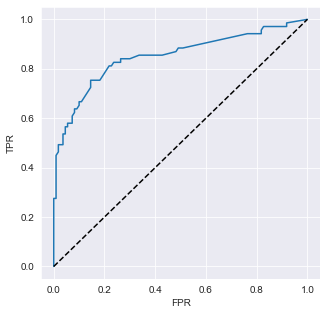

gb AUROC: 0.872463768115942


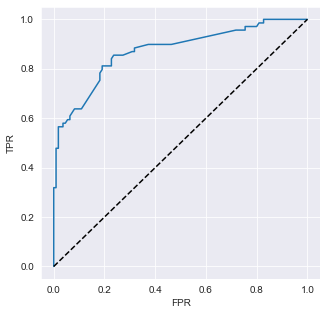

In [388]:
# Evaluate performance on the test set - AUROC (Area Under the Receiving Operating Characteristic)

# loop fitted models test data
for name, model in fitted_models.items():
    
    # get probability score for AUROC input
    pred = model.predict_proba(X_test)
    pred = [p[1] for p in pred]
    
    # evaluate prediction using AUROC
    fpr, tpr, threshold = roc_curve(y_test, pred)
    
    # print AUROC score
    print(F'{name} AUROC:', roc_auc_score(np.array(y_test), pred) )
    
    # initialize plot
    plt.figure(figsize=(5,5))
    
    # plot curve
    plt.plot(fpr, tpr)
    
    # plot diagonal line
    plt.plot([0,1],[0,1], 'k--')
    
    #
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

In [340]:
# Examine the parameters of the best estimator
fitted_models['rf'].best_estimator_

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=3, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=50, n_jobs=None,
                                        oob_score=False, random_state=123,
                                        verbose=0, warm_start=False))],
         verbose=Fal

In [389]:
# save the best esimator
with open('final_model.pkl', 'wb') as f:
    pickle.dump(fitted_models['gb'].best_estimator_, f)

## Insights & Analysis

#### Key findings and results
The Titanic data set was fun to work with. Although it did not contain many features, each feature it did contain provided an opportunity to extract useful information. The data dictionary was useful, however some key questions could not be answered without addition domain knowledge, such as:
* what do the letters in the Ticket column represent?
* why are there so many missing Cabin values?
* what is the definition behind the code of the Cabin values?

The best estimator test AUROC score of 0.87 should give me a good chance in the competition.

Overall, I'm happy with the result as a first attempt. Now that the workflow is in place, further experimenting and testing will be easy to do.

#### Winning model
The winning model was a gradient boosting classifier
* cross validation score 0.83
* AUROC score 0.87

#### What I learned
One thing I learned is to be careful not to spend too much time in the exploratory analysis phase. Unfortunately, I did not have an 'ah-ha' moment, and had to decide when to stop and move on to the next section. I discovered that a high score can be achieved by performing simple cleaning and engineering tasks such as:
1. filling missing values 
2. removing sparse catories
3. creating dummy variables

For example, the GradientBoostingClassifier achieved an equivalent cross-validation score without feature engineering or dimensionality reduction. However, the final model achieved a higher AUROC score.

#### Expanding on this project
Some important next steps will be to examine feature importance with a view to removing irrelevant features and further reducing complexity. In addition, the gradient boosting classfier is known for high performance with extensive tuning. More research into the tuning possibilities would surely help with improving performace. There are also outliers detected in the Fare feature. Since outliers are innocent until proven guilty, additional domain knowledge is needed to determine if some are guilty and how best to replace them.

#### Additional data to aquire
I would like to aquire additional observations to assist with both the Exploratory Analysis and Model Training. The Titanic reportedly had over 3000 people on board including crew, and so the number of observations is relativley low in this current set. Also, Addition features on passenger health would be useful in predicting survival.

### Additional resources

splitting string values
https://datatofish.com/left-right-mid-pandas/

grouping continuous numbers into buckets
https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/


### Confirm the model

In [390]:
# Load final_model.pkl as model
model = pd.read_pickle('final_model.pkl')
model

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.05, loss='deviance',
                                            max_depth=5, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100,
                                            n_iter_no

In [391]:
# analytical_base_table.csv to data frame
abt = pd.read_csv('analytical_base_table.csv', index_col='PassengerId')
abt.head(3)

,Survived,is_female,cabin_is_missing,is_without_family,ticket_size_group,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,age_group_1,age_group_2,age_group_3,age_group_4,price_group_1,price_group_2,price_group_3
PassengerId,,,,,,,,,,,,,,,,,,
1,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0
3,1,1,1,1,1,0,0,1,0,0,1,0,1,0,0,1,0,0
5,0,0,1,1,1,0,0,1,0,0,1,0,0,1,0,1,0,0


In [392]:
# define X and y variables
X = abt.drop(labels='Survived', axis=1)
y = abt.Survived

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=123,
                                                    stratify=abt.Survived                                                   
                                                   )

In [393]:
# generate prediction

pred = model.predict_proba(X_test)
pred = [p[1] for p in pred]

# print AUROC
print('AUROC: ', roc_auc_score(y_test, pred))

AUROC:  0.872463768115942


### Process new data

In [394]:
test_df = pd.read_csv('test.csv', index_col='PassengerId')
print(test_df.shape)
test_df.head()

(418, 10)


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [395]:
# prepare data frame for model
test_df = (test_df
           .pipe(clean_data)
           .pipe(engineer_features)
          )
print(test_df.shape)


(418, 17)


In [397]:
# generate prediction and apply to new column
test_df['Survived'] = model.predict(test_df)

In [398]:
test_df['Survived'].describe()

count    418.000000
mean       0.313397
std        0.464430
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

In [399]:
test_df.sort_index(inplace=True)

In [400]:
test_df['Survived'].to_csv('gender_submission.csv')